In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
import warnings
import seaborn as sns
# To suppress all warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import  r2_score as r2
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
import seaborn as sns
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from database import Magneticum
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

In [3]:
def data_manupulation(df):
    dff = df.copy()
    dff = dff[['Yksz','M','gas_frac','Vz']]
    q_list = [0,0.25,0.5,0.75,1]
    labels = [1,2,3,4]
    dff['M_q'] = pd.qcut(dff['M'],q=q_list,labels=labels)
    return dff

In [4]:
snaps = ['140','132','096']

In [47]:
boxno = 50

In [48]:
df_140 = Analysis(boxno,'140','').get_dataframe()
df_132 = Analysis(boxno,'132','').get_dataframe()


In [42]:
df_096 = Analysis(80,'096','').get_dataframe()

In [50]:
df_140_m = data_manupulation(df_140)
df_132_m = data_manupulation(df_132)
df_096_m = data_manupulation(df_096)

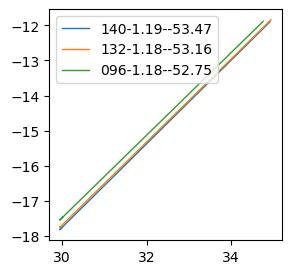

In [18]:
plt.figure(figsize=(3,3))
i = 0
rmse = []
r2 = []
for df in [df_140_m,df_132_m,df_096_m]:
    slope, intercept = np.polyfit(df.M, df.Yksz, 1)
    best_fit_line = slope*df.M+intercept
    rmse.append(mean_squared_error(df.Yksz, best_fit_line,squared=False))
    r2.append(r2_score(df.Yksz, best_fit_line))
    plt.plot(df.M, best_fit_line,linewidth=1,label=f'{snaps[i]}-{slope:.2f}-{intercept:.2f}')
    i+=1
plt.legend()

In [10]:
rmse

[1.144756036078561, 1.1447587085569164, 1.1244581168776409]

In [11]:
r2

[0.34849521792878235, 0.3381751247675967, 0.3025901128859617]

In [12]:
def fit_regression_models(df, features, target,df_test=None):
    print(f'Features: {features}')
    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=df.M_q, random_state=42)

    

    # Initialize regression models
    models = {
        "Random Forest Regression": RandomForestRegressor(max_depth=10,min_samples_leaf=4,min_samples_split=10,n_estimators=200, random_state=42),
        "XGB": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "GradientBoost": GradientBoostingRegressor(random_state=42),
        }

    results = {}

    for model_name, model in models.items():
        print(f'Running {model_name}...')
        # Fit the model
        # if model_name == "Perceptron":
        #     model.fit(X_train, y_train,)
        # else:
        model.fit(X_train, y_train,sample_weight=np.sqrt(X_train[:,0]))

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {"RMSE": rmse, "R-squared": r2}

        if df_test is not None:
            assert type(df_test) == list
            for i,df_ in enumerate(df_test):
                X_ = df_[features].values.reshape(-1, len(features))
                y_ = df_[target].values
                _, X_test_, _, y_test_ = train_test_split(X_, y_, test_size=0.2,stratify=df_.M_q, random_state=42)
                y_pred_ = model.predict(X_test_)
                rmse = mean_squared_error(y_test_, y_pred_, squared=False)
                r2 = r2_score(y_test_, y_pred_)
                results[model_name][f"RMSE_{i}"] = rmse
                results[model_name][f"R-squared_{i}"] = r2
            

        # Plot the results
        # plt.clf()
        # plt.figure(figsize=(6, 4))
        # plt.scatter(X_test[:, 0], y_test, color='blue', label='True')
        # plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted')
        # plt.xlabel(features[0])
        # plt.ylabel(target)
        # plt.legend()
        # plt.title(f'{model_name} - RMSE: {rmse:.2f}, R-squared: {r2:.2f}')
        # plt.show()

    return results

In [51]:
results_M = fit_regression_models(df_140_m, ['M'], 'Yksz',[df_132_m,df_096_m])

# Fit models using '[M, Vz]'
results_Mgf = fit_regression_models(df_140_m, ['M', 'gas_frac'], 'Yksz',[df_132_m,df_096_m])

results_MgfVz = fit_regression_models(df_140_m, ['M', 'gas_frac','Vz'], 'Yksz',[df_132_m,df_096_m])


Features: ['M']
Running Random Forest Regression...


Running XGB...
Running GradientBoost...
Features: ['M', 'gas_frac']
Running Random Forest Regression...
Running XGB...
Running GradientBoost...
Features: ['M', 'gas_frac', 'Vz']
Running Random Forest Regression...
Running XGB...
Running GradientBoost...


In [52]:
results_Mgf

{'Random Forest Regression': {'RMSE': 1.1927761924314337,
  'R-squared': 0.315525220033935,
  'RMSE_0': 1.1406410778880594,
  'R-squared_0': 0.3468031031473774,
  'RMSE_1': 1.1203386173353118,
  'R-squared_1': 0.2976752025554702},
 'XGB': {'RMSE': 1.2087292569446209,
  'R-squared': 0.29709344230616275,
  'RMSE_0': 1.1498236928254388,
  'R-squared_0': 0.33624377985644316,
  'RMSE_1': 1.1448163324618263,
  'R-squared_1': 0.26665046029796524},
 'GradientBoost': {'RMSE': 1.1787174774005698,
  'R-squared': 0.3315653219823007,
  'RMSE_0': 1.127618765059093,
  'R-squared_0': 0.3616326208045174,
  'RMSE_1': 1.1094511701000969,
  'R-squared_1': 0.3112592558179803}}

In [53]:
results_MgfVz

{'Random Forest Regression': {'RMSE': 0.9091279675728624,
  'R-squared': 0.6023604597155146,
  'RMSE_0': 0.8483213336481846,
  'R-squared_0': 0.6387009039905613,
  'RMSE_1': 0.9001674667314977,
  'R-squared_1': 0.5465953015304794},
 'XGB': {'RMSE': 0.9170640678908968,
  'R-squared': 0.5953878859108301,
  'RMSE_0': 0.8519387247255514,
  'R-squared_0': 0.63561304888681,
  'RMSE_1': 0.8980127088775892,
  'R-squared_1': 0.5487633603886828},
 'GradientBoost': {'RMSE': 0.9043099013692115,
  'R-squared': 0.6065639976443584,
  'RMSE_0': 0.8504353941999998,
  'R-squared_0': 0.636897908213762,
  'RMSE_1': 0.8714524173175564,
  'R-squared_1': 0.5750608466109584}}

In [ ]:

# Print and compare the results
for feature_set, result in zip(['M', '[M, Mstar]', '[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MMstar, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    for model_name, metrics in result.items():
        print(f"{model_name} - RMSE: {metrics['RMSE']:.2f}, R-squared: {metrics['R-squared']:.2f}")
    print()

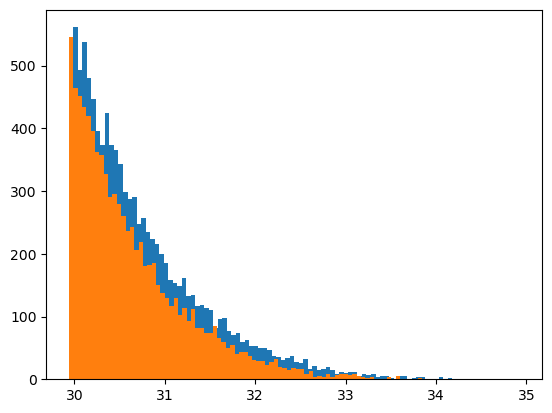

In [26]:
n = plt.hist(df_140_m.M,bins=100)
n = plt.hist(df_096_m.M,bins=100)

In [27]:
print('140',len(df_140_m.M))
print('096',len(df_096_m.M))

140 10493
096 8599


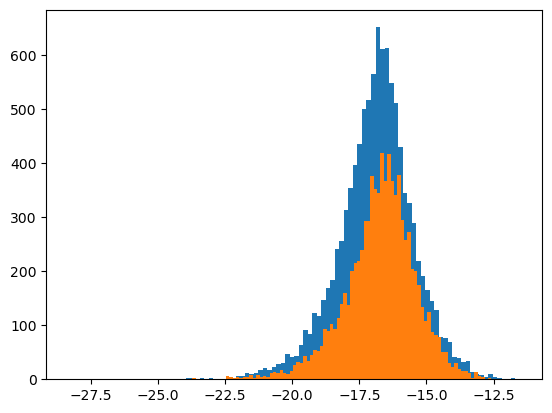

In [28]:
n = plt.hist(df_140_m.Yksz,bins=100)
n = plt.hist(df_096_m.Yksz,bins=100)

In [52]:
pearsonr(df_140_m.Yksz[df_140_m.M<33],df_140_m.M[df_140_m.M<33])

(0.5639905631636601, 0.0)

In [45]:
pearsonr(df_096_m.Yksz,df_096_m.M)

(0.5500819147054026, 0.0)

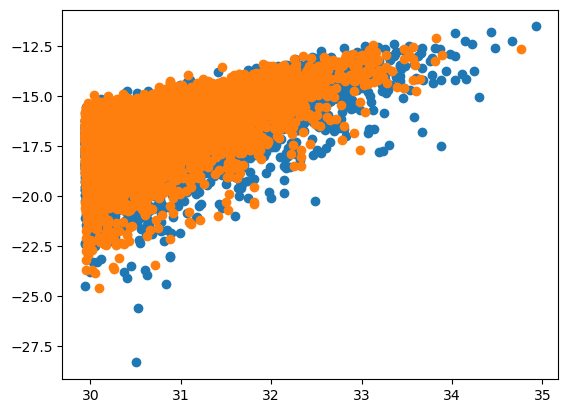

In [37]:
plt.scatter(df_140_m.M,df_140_m.Yksz)
plt.scatter(df_096_m.M,df_096_m.Yksz)

In [46]:
df_140_m.M_q.value_counts() 

1    2624
2    2623
3    2623
4    2623
Name: M_q, dtype: int64

In [47]:
df_096_m.M_q.value_counts()

1    2150
2    2150
4    2150
3    2149
Name: M_q, dtype: int64

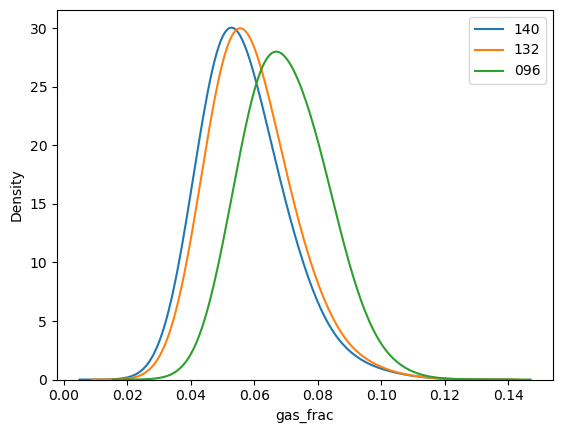

In [30]:
sns.kdeplot(df_140.gas_frac,bw_adjust=3,label='140')
sns.kdeplot(df_132.gas_frac,bw_adjust=3,label='132')
sns.kdeplot(df_096.gas_frac,bw_adjust=3,label='096')
plt.legend()